# plot global mean profile 

In [16]:
%matplotlib inline
import xarray as xr
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from config_calc import *
plt.rcParams['mathtext.default']='regular'

### read the mask

In [17]:
mask_file_in = '/glade/p/ncgd0033/obs/woa2013v2/1x1d/woa_region_mask.nc'
dsm = xr.open_dataset(mask_file_in)
dsm

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, region: 5)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon             (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: region
Data variables:
    area            (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 ...
    mask            (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    kmt             (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    REGION_MASK_3D  (region, lat, lon) float64 nan nan nan nan nan nan nan ...
    region_names    (region) |S14 'Global' 'Pacific' 'Atlantic' 'Indian' ...

In [18]:
region_names = dsm.region_names.values
region_names

array(['Global', 'Pacific', 'Atlantic', 'Indian', 'Southern Ocean'], 
      dtype='|S14')

### read the WOA data

In [19]:
woapth = '/glade/p/ncgd0033/obs/woa2013v2/1x1d'

woa = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'O2sat': {'varname': 'O_an', 'file': os.path.join(woapth,'woa13_all_O00_01.nc')},
    'AOU': {'varname': 'A_an', 'file' : os.path.join(woapth,'woa13_all_A00_01.nc')},    
    'T' : {'varname': 't_an', 'file': os.path.join(woapth,'woa13_decav_t00_01v2.nc')},
    'S' : {'varname': 's_an', 'file': os.path.join(woapth,'woa13_decav_s00_01v2.nc')},
    'NO3' : {'varname': 'n_an', 'file': os.path.join(woapth,'woa13_all_n00_01.nc')},
    'PO4' : {'varname': 'p_an', 'file': os.path.join(woapth,'woa13_all_p00_01.nc')}}

ds = {}
for v,info in woa.items():   
    varname = info['varname']
    file_in = info['file']
    dsi = xr.open_dataset(file_in,decode_times=False)
    dsi = dsi.drop([k for k in dsi if k not in [varname,'lat','lon','depth','depth_bnds']])
    dsi = dsi.rename({varname:v})
    if ds:
        ds = xr.merge((ds,dsi))
    else:
        ds = dsi
         
ni = len(ds.lon)
nj = len(ds.lat)

mlperl_2_mmolm3 = 1e6 / 1e3 / 22.3916
for v in ['O2','AOU']:
    ds[v] = ds[v] * mlperl_2_mmolm3
    ds[v].attrs['units'] = 'mmol m$^{-3}$'
ds['area'] = dsm.area
ds = ds.isel(time=0)
ds

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2sat       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2          (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    NO3         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan 

### add dz

In [20]:
ds['dz'] = (ds.depth_bnds[:,1:] - ds.depth_bnds[:,:-1])[:,0]
ds

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2sat       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2          (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    NO3         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan 

### compute area weights for spatial mean

In [21]:
ds['vol'] = ds.dz * ds.area
for j in range(len(ds.lat)):
    for i in range(len(ds.lon)):
        k = dsm.kmt.values[j,i].astype(int) - 1 
        ds['vol'].values[k:,j,i] = 0.
ds    

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2sat       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2          (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    NO3         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan 

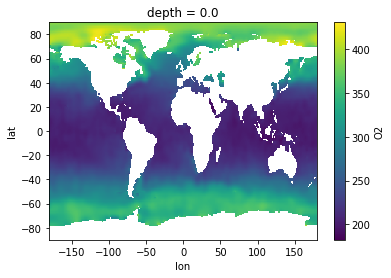

In [22]:
ds.O2[0,:,:].plot()

### compute O2sat in µM

In [23]:
ds['O2sat'] = ds.AOU + ds.O2

### mask the global ocean

In [24]:
i = np.where(region_names == 'Global')[0][0]
ds_masked = ds.where(dsm.REGION_MASK_3D[i,:,:]==1)
ds_masked

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (depth, nbounds, lat, lon) float32 nan nan nan nan nan nan ...
    PO4         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2sat       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T           (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2          (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    NO3         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan .

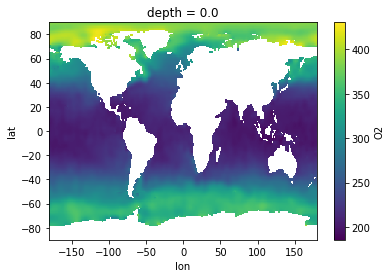

In [25]:
ds_masked.O2[0,:,:].plot()

In [30]:
wgt = ds_masked.vol.copy()
wgt = ds_masked.vol / ds_masked.vol.sum(dim=('lat','lon'))
wgt

<xarray.DataArray 'vol' (depth: 102, lat: 180, lon: 360)>
array([[[           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan],
        ..., 
        [  9.376143e-07,   9.376143e-07, ...,   9.376143e-07,   9.376143e-07],
        [  3.125698e-07,   3.125698e-07, ...,   3.125698e-07,   3.125698e-07]],

       [[           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan],
        ..., 
        [  9.380754e-07,   9.380754e-07, ...,   9.380754e-07,   9.380754e-07],
        [  3.127236e-07,   3.127236e-07, ...,   3.127236e-07,   3.127236e-07]],

       ..., 
       [[           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan],
        ..., 
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.0

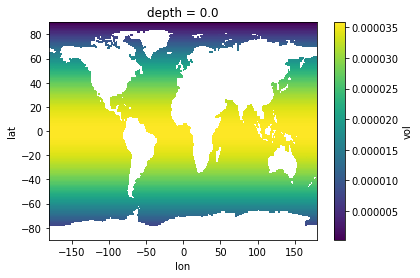

In [31]:
wgt[0,:,:].plot()

### compute vol-weighted lateral mean

In [32]:
dsg = (ds_masked*wgt).sum(dim=('lat','lon'))
dsg

<xarray.Dataset>
Dimensions:     (depth: 102, nbounds: 2)
Coordinates:
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (depth, nbounds) float64 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (depth) float64 0.5337 0.5348 0.5349 0.542 0.5487 0.5571 ...
    S           (depth) float64 34.66 34.68 34.71 34.73 34.76 34.78 34.8 ...
    O2sat       (depth) float64 249.5 249.6 249.8 250.0 250.3 250.6 251.1 ...
    AOU         (depth) float64 -0.8799 -0.8246 -0.6665 -0.2089 0.3179 1.185 ...
    T           (depth) float64 18.24 18.21 18.17 18.12 18.05 17.96 17.84 ...
    O2          (depth) float64 250.4 250.5 250.5 250.2 249.9 249.4 248.9 ...
    NO3         (depth) float64 5.259 5.269 5.326 5.393 5.479 5.602 5.753 ...
    area        (depth) float64 9.997e+09 9.997e+09 9.996e+09 9.996e+09 ...
    dz          (depth) float64 2.5 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 ...
    vol    

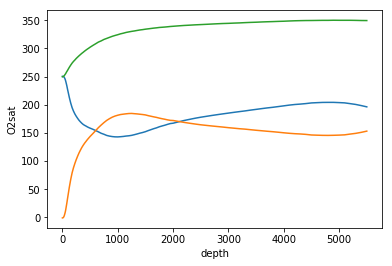

In [33]:
dsg.O2.plot(); dsg.AOU.plot(); dsg.O2sat.plot()